The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 目标检测数据集
:label:`sec_object-detection-dataset`

目标检测领域没有像MNIST和Fashion-MNIST那样的小数据集。
为了快速测试目标检测模型，[**我们收集并标记了一个小型数据集**]。
首先，我们拍摄了一组香蕉的照片，并生成了1000张不同角度和大小的香蕉图像。
然后，我们在一些背景图片的随机位置上放一张香蕉的图像。
最后，我们在图片上为这些香蕉标记了边界框。

## [**下载数据集**]

包含所有图像和CSV标签文件的香蕉检测数据集可以直接从互联网下载。


In [1]:
%matplotlib inline
import os
import pandas as pd
from mxnet import gluon, image, np, npx
from d2l import mxnet as d2l

npx.set_np()

In [2]:
#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

## 读取数据集

通过`read_data_bananas`函数，我们[**读取香蕉检测数据集**]。
该数据集包括一个的CSV文件，内含目标类别标签和位于左上角和右下角的真实边界框坐标。


In [3]:
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(image.imread(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, np.expand_dims(np.array(targets), 1) / 256

通过使用`read_data_bananas`函数读取图像和标签，以下`BananasDataset`类别将允许我们[**创建一个自定义`Dataset`实例**]来加载香蕉检测数据集。


In [4]:
#@save
class BananasDataset(gluon.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].astype('float32').transpose(2, 0, 1),
                self.labels[idx])

    def __len__(self):
        return len(self.features)

最后，我们定义`load_data_bananas`函数，来[**为训练集和测试集返回两个数据加载器实例**]。对于测试集，无须按随机顺序读取它。


In [5]:
#@save
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = gluon.data.DataLoader(BananasDataset(is_train=True),
                                       batch_size, shuffle=True)
    val_iter = gluon.data.DataLoader(BananasDataset(is_train=False),
                                     batch_size)
    return train_iter, val_iter

让我们[**读取一个小批量，并打印其中的图像和标签的形状**]。
图像的小批量的形状为（批量大小、通道数、高度、宽度），看起来很眼熟：它与我们之前图像分类任务中的相同。
标签的小批量的形状为（批量大小，$m$，5），其中$m$是数据集的任何图像中边界框可能出现的最大数量。

小批量计算虽然高效，但它要求每张图像含有相同数量的边界框，以便放在同一个批量中。
通常来说，图像可能拥有不同数量个边界框；因此，在达到$m$之前，边界框少于$m$的图像将被非法边界框填充。
这样，每个边界框的标签将被长度为5的数组表示。
数组中的第一个元素是边界框中对象的类别，其中-1表示用于填充的非法边界框。
数组的其余四个元素是边界框左上角和右下角的（$x$，$y$）坐标值（值域在0到1之间）。
对于香蕉数据集而言，由于每张图像上只有一个边界框，因此$m=1$。


In [6]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples


read 100 validation examples


((32, 3, 256, 256), (32, 1, 5))

## [**演示**]

让我们展示10幅带有真实边界框的图像。
我们可以看到在所有这些图像中香蕉的旋转角度、大小和位置都有所不同。
当然，这只是一个简单的人工数据集，实践中真实世界的数据集通常要复杂得多。


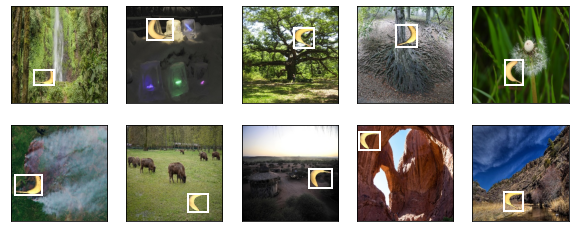

In [7]:
imgs = (batch[0][0:10].transpose(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 小结

* 我们收集的香蕉检测数据集可用于演示目标检测模型。
* 用于目标检测的数据加载与图像分类的数据加载类似。但是，在目标检测中，标签还包含真实边界框的信息，它不出现在图像分类中。

## 练习

1. 在香蕉检测数据集中演示其他带有真实边界框的图像。它们在边界框和目标方面有什么不同？
1. 假设我们想要将数据增强（例如随机裁剪）应用于目标检测。它与图像分类中的有什么不同？提示：如果裁剪的图像只包含物体的一小部分会怎样？


[Discussions](https://discuss.d2l.ai/t/3203)
